Numero di punti MC: 500000
Numero di punti MD: 500000
Autocorrelazione diretta MC calcolata in 4.35 s
Autocorrelazione diretta MD calcolata in 4.38 s
Autocorrelazione FFT MC calcolata in 0.25 s
Autocorrelazione FFT MD calcolata in 0.37 s


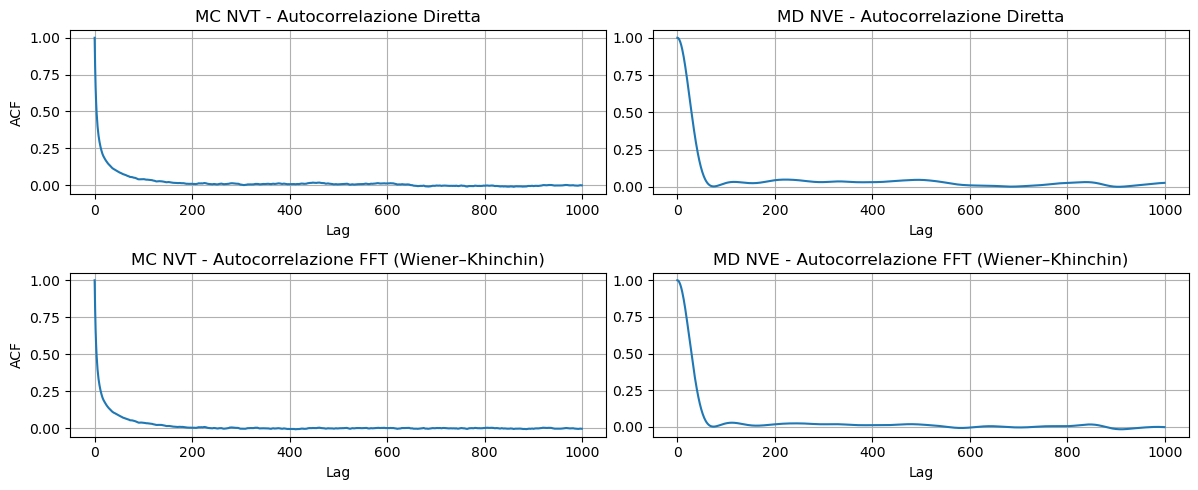

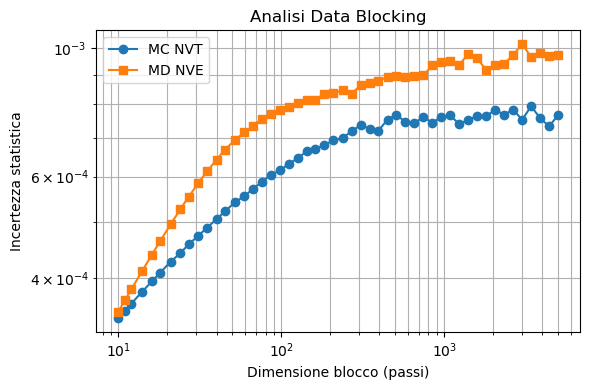

In [1]:
import numpy as np                                   # Importa NumPy per array e operazioni numeriche
import matplotlib.pyplot as plt                      # Importa Matplotlib per la creazione di grafici
import time                                          # Importa time per misurare i tempi di calcolo

def autocorrelation_direct(x, max_lag=1000):
    """Calcola l'autocorrelazione diretta solo fino a max_lag."""
    n = len(x)                                       # Numero totale di punti nella serie x
    x_mean = np.mean(x)                              # Media di x
    x_var = np.var(x)                                # Varianza di x

    if x_var == 0:                                   # Se la varianza è zero (serie costante)
        return np.zeros(max_lag)                     # restituisco un array di zeri, nessuna correlazione

    acf = np.zeros(max_lag)                          # Inizializzo vettore per l'autocorrelazione
    for t in range(max_lag):                         # Ciclo sui lag da 0 a max_lag-1
        sum_product = np.mean(x[:n - t] * x[t:])     # Calcola < x[i] * x[i+t] > per i da 0 a n-t-1
        acf[t] = (sum_product - x_mean**2) / x_var    # Normalizzo: [<x x_shifted> - μ^2] / var
    return acf                                       # Restituisco il vettore ACF non normalizzato a 1 in t=0

def autocorrelation_fft(x, max_lag=1000):
    """Calcola l'autocorrelazione normalizzata usando FFT (Teorema di Wiener–Khinchin)."""
    x = x - np.mean(x)                               # Centro la serie sottraendo la media
    n = len(x)                                       # Lunghezza originale della serie
    f = np.fft.fft(x, n=2*n)                         # Calcolo FFT con zero-padding a lunghezza 2n per evitare aliasing
    acf = np.fft.ifft(f * np.conjugate(f))[:n].real  # IFFT del prodotto per ottenere l'autocorrelazione completa, prendo solo la parte reale e i primi n elementi
    acf /= acf[0]                                    # Normalizzo in modo che acf[0] == 1
    return acf[:max_lag]                             # Restituisco solo i primi max_lag valori

def block_analysis(data, max_block_size=5000):
    """
    Esegue l'analisi di data blocking su 'data', restituendo le dimensioni dei blocchi
    e le incertezze stimate per ciascun blocco.
    """
    raw_bs = np.logspace(1, np.log10(max_block_size), 50)  # Creo 50 dimensioni di blocco logaritmiche tra 10^1 e max_block_size
    block_sizes = np.unique(raw_bs.astype(int))            # Converto a interi e rimuovo duplicati
    uncertainties = []                                      # Lista per memorizzare incertezze per ciascun blocco
    used_bs = []                                            # Lista per memorizzare blocchi effettivamente usati

    for bs in block_sizes:                                  # Ciclo su ciascuna dimensione di blocco proposta
        if bs > len(data) // 2:                             # Se il blocco è più di metà della serie, lo salto
            continue
        n_blocks = len(data) // bs                          # Numero intero di blocchi di lunghezza bs
        # Ritaglio la serie per avere blocchi tutti della stessa dimensione
        blocks = data[:bs * n_blocks].reshape(n_blocks, bs).mean(axis=1)
        # Calcolo deviazione standard delle medie di blocco e la divido per sqrt(n_blocks)
        uncertainties.append(blocks.std(ddof=1) / np.sqrt(n_blocks))
        used_bs.append(bs)                                  # Memorizzo la dimensione del blocco che ho usato

    return np.array(used_bs), np.array(uncertainties)       # Restituisco le dimensioni e le incertezze corrispondenti

def load_scalar(filename, col=1, skip_lines=1):
    """
    Carica una colonna scalare da un file di testo. 
    - filename: nome del file
    - col: indice della colonna da leggere
    - skip_lines: numero di righe di intestazione da saltare
    """
    try:
        return np.loadtxt(
            filename,
            dtype=float,
            skiprows=skip_lines,
            usecols=[col]
        )
    except Exception as e:
        print(f"Errore nel caricamento di {filename}: {e}")
        return None

# -------------------------
#  1) Caricamento dati MC e MD
# -------------------------
U_mc = load_scalar('nvt1.txt', col=1)    # Carica U/N simulazione MC NVT (colonna 1, salta prima riga)
U_md = load_scalar('nve1.txt', col=1)    # Carica U/N simulazione MD NVE (colonna 1, salta prima riga)
if U_mc is None or U_md is None:         # Controllo che il caricamento sia avvenuto correttamente
    raise SystemExit("Errore nel caricamento dei dati.")

print(f"Numero di punti MC: {len(U_mc)}") # Stampa numero di campioni MC
print(f"Numero di punti MD: {len(U_md)}") # Stampa numero di campioni MD

# -------------------------
#  2) Calcolo dell'autocorrelazione
# -------------------------
max_lag = 1000                           # Numero massimo di lag per cui calcolare l'autocorrelazione

# 2a) Metodo diretto MC
start = time.time()                      # Misuro tempo d'inizio
acf_mc_direct = autocorrelation_direct(U_mc, max_lag=max_lag)
print(f"Autocorrelazione diretta MC calcolata in {time.time() - start:.2f} s")

# 2b) Metodo diretto MD
start = time.time()
acf_md_direct = autocorrelation_direct(U_md, max_lag=max_lag)
print(f"Autocorrelazione diretta MD calcolata in {time.time() - start:.2f} s")

# 2c) Metodo FFT MC (Wiener–Khinchin)
start = time.time()
acf_mc_fft = autocorrelation_fft(U_mc, max_lag=max_lag)
print(f"Autocorrelazione FFT MC calcolata in {time.time() - start:.2f} s")

# 2d) Metodo FFT MD (Wiener–Khinchin)
start = time.time()
acf_md_fft = autocorrelation_fft(U_md, max_lag=max_lag)
print(f"Autocorrelazione FFT MD calcolata in {time.time() - start:.2f} s")

# -------------------------
#  3) Plot dei risultati di autocorrelazione
# -------------------------
plt.figure(figsize=(12, 5))            # Imposta dimensione figura

# 3a) Autocorrelazione diretta MC
plt.subplot(2, 2, 1)                   # Sottoplot in posizione 2x2, riga 1 colonna 1
plt.plot(acf_mc_direct)                # Disegna acf MC diretto
plt.title('MC NVT - Autocorrelazione Diretta')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid()

# 3b) Autocorrelazione diretta MD
plt.subplot(2, 2, 2)                   # Sottoplot riga 1 colonna 2
plt.plot(acf_md_direct)                # Disegna acf MD diretto
plt.title('MD NVE - Autocorrelazione Diretta')
plt.xlabel('Lag')
plt.grid()

# 3c) Autocorrelazione FFT MC
plt.subplot(2, 2, 3)                   # Sottoplot riga 2 colonna 1
plt.plot(acf_mc_fft)                   # Disegna acf MC via FFT
plt.title('MC NVT - Autocorrelazione FFT (Wiener–Khinchin)')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid()

# 3d) Autocorrelazione FFT MD
plt.subplot(2, 2, 4)                   # Sottoplot riga 2 colonna 2
plt.plot(acf_md_fft)                   # Disegna acf MD via FFT
plt.title('MD NVE - Autocorrelazione FFT (Wiener–Khinchin)')
plt.xlabel('Lag')
plt.grid()

plt.tight_layout()                     # Ottimizza spaziatura tra i subplots
plt.savefig('autocorrelation_comparison.png')  # Salva l’immagine su file
plt.show()                             # Mostra la figura

# -------------------------
#  4) Data blocking e plot incertezza vs block size
# -------------------------
bs_mc, err_mc = block_analysis(U_mc)    # Esegue block analysis su dati MC
bs_md, err_md = block_analysis(U_md)    # Esegue block analysis su dati MD

plt.figure(figsize=(6, 4))             # Nuova figura per block analysis
plt.loglog(bs_mc, err_mc, 'o-', label='MC NVT')  # Plot log-log incertezza vs block size MC
plt.loglog(bs_md, err_md, 's-', label='MD NVE')  # Plot log-log incertezza vs block size MD
plt.xlabel('Dimensione blocco (passi)')
plt.ylabel('Incertezza statistica')
plt.title('Analisi Data Blocking')
plt.legend()
plt.grid(True, which='both')            # Griglia sia su asse x che y
plt.tight_layout()
plt.savefig('block_analysis.png')      # Salva l’immagine su file
plt.show()                             # Mostra il grafico


### Analisi Approfondita dei Risultati: Autocorrelazione dell'Energia Potenziale e Dimensioni Ottimali dei Blocchi

#### 1. Autocorrelazione dell’Energia Potenziale ($U/N$)

**Comportamento delle curve di autocorrelazione**:

- **MC NVT (Stocastico)**:
  - Decadimento rapido: l’autocorrelazione scende rapidamente a zero entro circa 50 passi.
  - Oscillazioni residue: dopo la discesa iniziale, si osservano fluttuazioni casuali vicino allo zero, tipiche del rumore statistico nei processi markoviani.
  - Motivazione fisica: gli aggiornamenti casuali di Metropolis rompono rapidamente le correlazioni.

- **MD NVE (Deterministico)**:
  - Decadimento lento: l’autocorrelazione persiste oltre i 200 passi.
  - Oscillazioni strutturate: le fluttuazioni intorno allo zero risultano più regolari, riflettendo la natura conservativa della dinamica Hamiltoniana.
  - Picchi a lag lunghi: si osservano leggeri rimbalzi anche a lag $\sim 800$, indicativi di ricorrenze periodiche nelle traiettorie.

**Confronto FFT vs Metodo Diretto**:

- Entrambi i metodi forniscono risultati sovrapponibili, confermando l’equivalenza teorica garantita dal teorema di Wiener-Khinchin.
- **Metodo FFT**:
  - Complessità algoritmica $O(N \log N)$
  - Tempi di calcolo molto rapidi: 0.25s (MC) e 0.37s (MD)
- **Metodo Diretto**:
  - Complessità $O(N^2)$
  - Tempi molto più lunghi: circa 4.35s (MC) e 4.38s (MD)
- La FFT è quindi preferibile per serie temporali lunghe (es. $N = 500,\!000$), garantendo velocità e precisione.

---

#### 2. Dimensioni Ottimali dei Blocchi

**Comportamento dell’incertezza statistica al variare della dimensione del blocco ($L$)**:

- **Per $L < L_{\text{min}}$**:
  - Gli errori stimati crescono all’aumentare di $L$
  - I blocchi sono ancora correlati → l’incertezza è sottostimata
  - Questo causa un’illusione di precisione nei risultati

- **Per $L \geq L_{\text{min}}$**:
  - L’incertezza raggiunge un **plateau stabile**: i blocchi sono ora statisticamente indipendenti
  - Si ottiene una stima corretta dell’errore statistico

**Stime delle dimensioni minime del blocco e incertezze corrispondenti**:
- MC NVT: $L_{\text{min}} \approx 250$ passi, $\sigma_U \approx 6 \times 10^{-4}$
- MD NVE: $L_{\text{min}} \approx 1000$ passi, $\sigma_U \approx 4 \times 10^{-4}$

**Conclusione**:
La corretta scelta della dimensione del blocco è essenziale per una stima affidabile degli errori: troppo piccoli causano sottostima, troppo grandi riducono il numero di campioni indipendenti disponibili.
